<a href="https://colab.research.google.com/github/kimarlee/Tic-Tac-Toe/blob/main/Dina_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.6'
spark_version = 'spark-3.5.6'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
# Import packages
from pyspark.sql import SparkSession  # entry point to using Spark with DataFrames and SQL
import time                           # time module so we can time our queries.

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [ ]:
# 1. Read the tic_tac_toe_data.csv into a PySpark DataFrame.
from pyspark import SparkFiles   # entry point to using Spark with DataFrames and SQL
url = "https://raw.githubusercontent.com/kimarlee/Tic-Tac-Toe/refs/heads/main/tic_tac_toe_data.csv"

# Downloads the file - this step makes the file accessible locally within your Spark session — even though it came from a remote URL.
spark.sparkContext.addFile(url)

# Read the data into the dataframe
df = spark.read.csv(SparkFiles.get("tic_tac_toe_data.csv"), sep=",", inferSchema=True, header=True)
df.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     X|               0-0|               0-1|               1-0|               0-2|               2-0|               ---|               ---|               ---|               ---|
|     X|               0-0|               0-1|               1-0|               1-1|               2-0|               ---|               ---|               ---|               ---|
|     X|               0-0|               0-1|               1-0|               1-2|               2

In [ ]:
df.createOrReplaceTempView("tictactoe_games")

In [ ]:
# It comes out as Strings

from pyspark.sql.functions import col, when

# Get the list of move columns
move_columns = [c for c in df.columns if c.startswith('Move')]

# Replace NULL values with 9 for all move columns
for column_name in move_columns:
    df = df.withColumn(
        column_name,
        when(col(column_name).isNull(), 9).otherwise(col(column_name))
    )

# Select only the 'Winner' column and the move columns
df = df.select('Winner', *move_columns)

# Show the result
df.show(truncate=False)

# Print the schema to confirm the data types
df.printSchema()


+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|X     |0-0               |0-1               |1-0               |0-2               |2-0               |---               |---               |---               |---               |
|X     |0-0               |0-1               |1-0               |1-1               |2-0               |---               |---               |---               |---               |
|X     |0-0               |0-1               |1-0               |1-2               |2-0             

In [ ]:
# First Attempt

from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when

# Prepare the data
move_columns = [col for col in df.columns if col.startswith('Move')]

# Replace null values with 'Empty' for all move columns
for column in move_columns:
    df = df.withColumn(column, when(col(column).isNull(), "Empty").otherwise(col(column)))

# Create stages for the pipeline
stages = []

# Convert Winner to numeric
labelIndexer = StringIndexer(inputCol="Winner", outputCol="label")
stages.append(labelIndexer)

# Create StringIndexer and OneHotEncoder for each move column
encoded_move_columns = []
for move_col in move_columns:
    # StringIndexer
    indexer = StringIndexer(inputCol=move_col, outputCol=f"{move_col}_indexed", handleInvalid="keep")
    stages.append(indexer)

    # OneHotEncoder
    encoder = OneHotEncoder(inputCol=f"{move_col}_indexed", outputCol=f"{move_col}_encoded", handleInvalid="keep")
    stages.append(encoder)
    encoded_move_columns.append(f"{move_col}_encoded")

# Assemble features
assembler = VectorAssembler(inputCols=encoded_move_columns, outputCol="features")
stages.append(assembler)

# Create and train the model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
stages.append(rf)

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Get the label mapping
label_mapping = {float(idx): category for idx, category in enumerate(model.stages[0].labels)}
print("Label Mapping:", label_mapping)

# Print confusion matrix
from pyspark.mllib.evaluation import MulticlassMetrics
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:")
print(metrics.confusionMatrix())

# Print classification report
for label in sorted(label_mapping.keys()):
    print(f"\nClass {label_mapping[label]}:")
    print(f"Precision = {metrics.precision(label)}")
    print(f"Recall = {metrics.recall(label)}")
    print(f"F1 Score = {metrics.fMeasure(label)}")

Accuracy: 0.8023208708492872
Label Mapping: {0.0: 'X', 1.0: 'O', 2.0: '-'}
Confusion Matrix:
DenseMatrix([[39369.,     0.,     0.],
             [ 1459., 22027.,     0.],
             [13668.,     0.,     0.]])

Class X:
Precision = 0.7224199941280094
Recall = 1.0
F1 Score = 0.8388430192297448

Class O:
Precision = 1.0
Recall = 0.9378778846972664
F1 Score = 0.9679432250126337

Class -:
Precision = 0.0
Recall = 0.0
F1 Score = 0.0


In [ ]:
# Change to Numbers in light of Second Attempt - SKIP!

# from pyspark.sql.functions import col, when
# from pyspark.sql.types import StringType

# Get the list of move columns
# move_columns = [c for c in df.columns if c.startswith('Move')]

# Function to convert "---" to "9"
# def convert_move(col_name):
#     return when(col(col_name) == "---", "9").otherwise(col(col_name))

# Apply the conversion to all move columns
# for column_name in move_columns:
#     df = df.withColumn(column_name, convert_move(column_name))

# Select only the 'Winner' column and the move columns
# df = df.select('Winner', *move_columns)

# Show the result
# print("Transformed Data:")
# df.show(truncate=False)

# Print the schema to confirm the data types
# print("\nUpdated DataFrame Schema:")
# df.printSchema()

In [ ]:
# Corrected version to Integers
from pyspark.sql.functions import col, when, split
from pyspark.sql.types import IntegerType

# Get the list of move columns
move_columns = [c for c in df.columns if c.startswith('Move')]

# Function to convert move notation to a single integer
def convert_move(col_name):
    return when(col(col_name) == "---", 9)\
           .otherwise(
               (split(col(col_name), "-")[0].cast("int") * 3 +
                split(col(col_name), "-")[1].cast("int"))
           )

# Apply the conversion to all move columns
for column_name in move_columns:
    df = df.withColumn(
        column_name,
        convert_move(column_name).cast(IntegerType())
    )

# Select only the 'Winner' column and the move columns
df = df.select('Winner', *move_columns)

# Show the result
print("Transformed Data:")
df.show(truncate=False)

# Print the schema to confirm the data types
print("\nUpdated DataFrame Schema:")
df.printSchema()

Transformed Data:
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|X     |0                 |1                 |3                 |2                 |6                 |9                 |9                 |9                 |9                 |
|X     |0                 |1                 |3                 |4                 |6                 |9                 |9                 |9                 |9                 |
|X     |0                 |1                 |3                 |5                

In [ ]:
# Second Attempt
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

# Get the list of move columns
move_columns = [col for col in df.columns if col.startswith('Move')]

# Create stages for the pipeline
stages = []

# Convert Winner to numeric
labelIndexer = StringIndexer(inputCol="Winner", outputCol="label")
stages.append(labelIndexer)

# Assemble features
assembler = VectorAssembler(inputCols=move_columns, outputCol="features")
stages.append(assembler)

# Create and train the model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
stages.append(rf)

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Get the label mapping
label_mapping = {float(idx): category for idx, category in enumerate(model.stages[0].labels)}
print("Label Mapping:", label_mapping)

# Print confusion matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:")
print(metrics.confusionMatrix())

# Print classification report
for label in sorted(label_mapping.keys()):
    print(f"\nClass {label_mapping[label]}:")
    print(f"Precision = {metrics.precision(label)}")
    print(f"Recall = {metrics.recall(label)}")
    print(f"F1 Score = {metrics.fMeasure(label)}")

Accuracy: 0.8213870339636449
Label Mapping: {0.0: 'X', 1.0: 'O', 2.0: '-'}
Confusion Matrix:
DenseMatrix([[39369.,     0.,     0.],
             [    0., 23486.,     0.],
             [13668.,     0.,     0.]])

Class X:
Precision = 0.7422931161264777
Recall = 1.0
F1 Score = 0.852087526783975

Class O:
Precision = 1.0
Recall = 1.0
F1 Score = 1.0

Class -:
Precision = 0.0
Recall = 0.0
F1 Score = 0.0


# Better but still having trouble with ties. Trying DecisionTree instead.

In [ ]:
# Third Attempt
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

# Get the list of move columns
move_columns = [col for col in df.columns if col.startswith('Move')]

# Create stages for the pipeline
stages = []

# Convert Winner to numeric
labelIndexer = StringIndexer(inputCol="Winner", outputCol="label")
stages.append(labelIndexer)

# Assemble features
assembler = VectorAssembler(inputCols=move_columns, outputCol="features")
stages.append(assembler)

# Create and train the model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=10)
stages.append(dt)

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Get the label mapping
label_mapping = {float(idx): category for idx, category in enumerate(model.stages[0].labels)}
print("Label Mapping:", label_mapping)

# Print confusion matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:")
print(metrics.confusionMatrix())

# Print classification report
for label in sorted(label_mapping.keys()):
    print(f"\nClass {label_mapping[label]}:")
    print(f"Precision = {metrics.precision(label)}")
    print(f"Recall = {metrics.recall(label)}")
    print(f"F1 Score = {metrics.fMeasure(label)}")

# Print feature importances
dt_model = model.stages[-1]
print("\nFeature Importances:")
for feature, importance in zip(move_columns, dt_model.featureImportances):
    print(f"{feature}: {importance}")

Accuracy: 0.880362766749866
Label Mapping: {0.0: 'X', 1.0: 'O', 2.0: '-'}
Confusion Matrix:
DenseMatrix([[35339.,     0.,  4030.],
             [    0., 23486.,     0.],
             [ 5125.,     0.,  8543.]])

Class X:
Precision = 0.8733442071965204
Recall = 0.8976351952043486
F1 Score = 0.8853231119962922

Class O:
Precision = 1.0
Recall = 1.0
F1 Score = 1.0

Class -:
Precision = 0.6794718841962937
Recall = 0.6250365817968979
F1 Score = 0.6511184787165123

Feature Importances:
Move 1-X (Row-Col): 0.01382707668664977
Move 2-O (Row-Col): 0.016495663824717694
Move 3-X (Row-Col): 0.014594043536041459
Move 4-O (Row-Col): 0.008625303580357332
Move 5-X (Row-Col): 0.011254574258243395
Move 6-O (Row-Col): 0.04539013296737967
Move 7-X (Row-Col): 0.07180314877789555
Move 8-O (Row-Col): 0.47585735223813824
Move 9-X (Row-Col): 0.34215270413057697


# Much, much better.

In [ ]:
# Fourth Attempt - Optimize by Incresing depth to 20.

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

# Get the list of move columns
move_columns = [col for col in df.columns if col.startswith('Move')]

# Create stages for the pipeline
stages = []

# Convert Winner to numeric
labelIndexer = StringIndexer(inputCol="Winner", outputCol="label")
stages.append(labelIndexer)

# Assemble features
assembler = VectorAssembler(inputCols=move_columns, outputCol="features")
stages.append(assembler)

# Create and train the model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=20)
stages.append(dt)

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Get the label mapping
label_mapping = {float(idx): category for idx, category in enumerate(model.stages[0].labels)}
print("Label Mapping:", label_mapping)

# Print confusion matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:")
print(metrics.confusionMatrix())

# Print classification report
for label in sorted(label_mapping.keys()):
    print(f"\nClass {label_mapping[label]}:")
    print(f"Precision = {metrics.precision(label)}")
    print(f"Recall = {metrics.recall(label)}")
    print(f"F1 Score = {metrics.fMeasure(label)}")

# Print feature importances
dt_model = model.stages[-1]
print("\nFeature Importances:")
for feature, importance in zip(move_columns, dt_model.featureImportances):
    print(f"{feature}: {importance}")

Accuracy: 0.9926427348640278
Label Mapping: {0.0: 'X', 1.0: 'O', 2.0: '-'}
Confusion Matrix:
DenseMatrix([[39137.,     0.,   232.],
             [    0., 23486.,     0.],
             [  331.,     0., 13337.]])

Class X:
Precision = 0.9916134590047634
Recall = 0.9941070385328558
F1 Score = 0.9928586831056483

Class O:
Precision = 1.0
Recall = 1.0
F1 Score = 1.0

Class -:
Precision = 0.9829022035522146
Recall = 0.9757828504536142
F1 Score = 0.9793295884275067

Feature Importances:
Move 1-X (Row-Col): 0.03932368747394982
Move 2-O (Row-Col): 0.05249921449997855
Move 3-X (Row-Col): 0.03130835596740921
Move 4-O (Row-Col): 0.04202429717300386
Move 5-X (Row-Col): 0.03697436458475791
Move 6-O (Row-Col): 0.06765544704979858
Move 7-X (Row-Col): 0.07763065507386602
Move 8-O (Row-Col): 0.39117996682469797
Move 9-X (Row-Col): 0.2614040113525382


In [ ]:
# Fifth Attempt - Optimize by changing depth to 15 just to see the impact.

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics

# Get the list of move columns
move_columns = [col for col in df.columns if col.startswith('Move')]

# Create stages for the pipeline
stages = []

# Convert Winner to numeric
labelIndexer = StringIndexer(inputCol="Winner", outputCol="label")
stages.append(labelIndexer)

# Assemble features
assembler = VectorAssembler(inputCols=move_columns, outputCol="features")
stages.append(assembler)

# Create and train the model
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxDepth=15)
stages.append(dt)

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Split the data into training and test sets
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)

# Train model
model = pipeline.fit(trainingData)

# Make predictions
predictions = model.transform(testData)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Get the label mapping
label_mapping = {float(idx): category for idx, category in enumerate(model.stages[0].labels)}
print("Label Mapping:", label_mapping)

# Print confusion matrix
predictionAndLabels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictionAndLabels)
print("Confusion Matrix:")
print(metrics.confusionMatrix())

# Print classification report
for label in sorted(label_mapping.keys()):
    print(f"\nClass {label_mapping[label]}:")
    print(f"Precision = {metrics.precision(label)}")
    print(f"Recall = {metrics.recall(label)}")
    print(f"F1 Score = {metrics.fMeasure(label)}")

# Print feature importances
dt_model = model.stages[-1]
print("\nFeature Importances:")
for feature, importance in zip(move_columns, dt_model.featureImportances):
    print(f"{feature}: {importance}")

Accuracy: 0.9538178064111443
Label Mapping: {0.0: 'X', 1.0: 'O', 2.0: '-'}
Confusion Matrix:
DenseMatrix([[37616.,     0.,  1753.],
             [    0., 23486.,     0.],
             [ 1781.,     0., 11887.]])

Class X:
Precision = 0.9547935121963601
Recall = 0.9554725799486906
F1 Score = 0.9551329253738923

Class O:
Precision = 1.0
Recall = 1.0
F1 Score = 1.0

Class -:
Precision = 0.8714809384164223
Recall = 0.8696956394498098
F1 Score = 0.8705873736633953

Feature Importances:
Move 1-X (Row-Col): 0.035655199481789135
Move 2-O (Row-Col): 0.041613825482074644
Move 3-X (Row-Col): 0.028080680562945708
Move 4-O (Row-Col): 0.028517903961890082
Move 5-X (Row-Col): 0.032685331157026154
Move 6-O (Row-Col): 0.062367682539362285
Move 7-X (Row-Col): 0.07630361349362776
Move 8-O (Row-Col): 0.4113231649336098
Move 9-X (Row-Col): 0.28345259838767456


# It does lose accuracy by going to 15.



---



# SQL

# Overall View

In [ ]:
# Full Table
spark.sql("""
    SELECT *
    FROM tictactoe_games
    Where Winner = 'O'
""").show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     O|               0-0|               0-1|               0-2|               1-1|               1-0|               2-1|               ---|               ---|               ---|
|     O|               0-0|               0-1|               0-2|               1-1|               1-2|               2-1|               ---|               ---|               ---|
|     O|               0-0|               0-1|               0-2|               1-1|               2

In [ ]:
spark.sql("""
    SELECT
        Winner
    FROM tictactoe_games
    Group by Winner
""").show(20)

+------+
|Winner|
+------+
|     O|
|     -|
|     X|
+------+



In [ ]:
# Games won by each
spark.sql("""
    SELECT
        Winner,
        CASE
            WHEN `Move 2-O (Row-Col)` = '---' THEN 1
            WHEN `Move 3-X (Row-Col)` = '---' THEN 2
            WHEN `Move 4-O (Row-Col)` = '---' THEN 3
            WHEN `Move 5-X (Row-Col)` = '---' THEN 4
            WHEN `Move 6-O (Row-Col)` = '---' THEN 5
            WHEN `Move 7-X (Row-Col)` = '---' THEN 6
            WHEN `Move 8-O (Row-Col)` = '---' THEN 7
            WHEN `Move 9-X (Row-Col)` = '---' THEN 8
            ELSE 9
        END AS number_of_moves,
        COUNT(*) as games_count
    FROM tictactoe_games
    GROUP BY Winner, number_of_moves
    ORDER BY Winner, number_of_moves
""").show(20)

+------+---------------+-----------+
|Winner|number_of_moves|games_count|
+------+---------------+-----------+
|     -|              9|      46080|
|     O|              6|       5328|
|     O|              8|      72576|
|     X|              5|       1440|
|     X|              7|      47952|
|     X|              9|      81792|
+------+---------------+-----------+



# X Win Data

In [ ]:
# Number of games X won
spark.sql("""
    SELECT COUNT(*) as X_wins
    FROM tictactoe_games
    WHERE Winner = 'X'
""").show()

+------+
|X_wins|
+------+
|131184|
+------+



In [ ]:
# Most common first move

spark.sql("""
    SELECT `Move 1-X (Row-Col)`, COUNT(*) as count
    FROM tictactoe_games
    WHERE Winner = 'X'
    GROUP BY `Move 1-X (Row-Col)`
    ORDER BY count DESC
    LIMIT 1
""").show()

+------------------+-----+
|Move 1-X (Row-Col)|count|
+------------------+-----+
|               1-1|15648|
+------------------+-----+



In [ ]:
# X won in 3 moves (5 moves Overall)

spark.sql("""
    SELECT *
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 6-O (Row-Col)` = '---'
""").show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     X|               0-0|               0-1|               1-0|               0-2|               2-0|               ---|               ---|               ---|               ---|
|     X|               0-0|               0-1|               1-0|               1-1|               2-0|               ---|               ---|               ---|               ---|
|     X|               0-0|               0-1|               1-0|               1-2|               2

In [ ]:
# X won in 3 moves (5 moves Overall) count

spark.sql("""
    SELECT COUNT(*) as X_wins
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 6-O (Row-Col)` = '---'
""").show()

+------+
|X_wins|
+------+
|  1440|
+------+



In [ ]:
# X won in 4 moves (7 moves Overall)

spark.sql("""
    SELECT *
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 6-O (Row-Col)` != '---' AND `Move 8-O (Row-Col)` = '---'
""").show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     X|               0-0|               0-1|               0-2|               1-0|               1-1|               1-2|               2-0|               ---|               ---|
|     X|               0-0|               0-1|               0-2|               1-0|               1-1|               1-2|               2-2|               ---|               ---|
|     X|               0-0|               0-1|               0-2|               1-0|               1

In [ ]:
# X won in 4 moves (7 moves Overall)

spark.sql("""
SELECT COUNT(*) as X_wins
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 6-O (Row-Col)` != '---' AND `Move 8-O (Row-Col)` = '---'
""").show()

+------+
|X_wins|
+------+
| 47952|
+------+



In [ ]:
# X won in 5 moves (9 moves Overall)

spark.sql("""
    SELECT *
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 9-X (Row-Col)` != '---'
""").show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     X|               0-0|               0-1|               0-2|               1-0|               1-1|               1-2|               2-1|               2-0|               2-2|
|     X|               0-0|               0-1|               0-2|               1-0|               1-1|               1-2|               2-1|               2-2|               2-0|
|     X|               0-0|               0-1|               0-2|               1-0|               1

In [ ]:
# X won in 5 moves count (9 moves Overall)

spark.sql("""
SELECT COUNT(*) as X_wins
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 9-X (Row-Col)` != '---'
""").show()

+------+
|X_wins|
+------+
| 81792|
+------+



In [ ]:
spark.sql("""
    SELECT
        COUNT(*) as games_count,
        COLLECT_LIST(
            CONCAT(
                `Move 1-X (Row-Col)`, ', ',
                `Move 2-O (Row-Col)`, ', ',
                `Move 3-X (Row-Col)`, ', ',
                `Move 4-O (Row-Col)`, ', ',
                `Move 5-X (Row-Col)`
            )
        ) as winning_sequences
    FROM tictactoe_games
    WHERE Winner = 'X' AND `Move 6-O (Row-Col)` = '---'
""").show(truncate=False)

+-----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Games won by X
spark.sql("""
    SELECT
        CASE
            WHEN `Move 6-O (Row-Col)` = '---' THEN '3 moves'
            WHEN `Move 8-O (Row-Col)` = '---' THEN '4 moves'
            WHEN `Move 9-X (Row-Col)` != '---' THEN '5 moves'
        END AS moves_to_win,
        COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = 'X'
    GROUP BY moves_to_win
    ORDER BY
        CASE moves_to_win
            WHEN '5 moves' THEN 1
            WHEN '7 moves' THEN 2
            WHEN '9 moves' THEN 3
        END
""").show()

+------------+-----------+
|moves_to_win|games_count|
+------------+-----------+
|     3 moves|       1440|
|     4 moves|      47952|
|     5 moves|      81792|
+------------+-----------+



# O Win Data

In [ ]:
# Number of games 0 won
spark.sql("""
    SELECT COUNT(*) as O_wins
    FROM tictactoe_games
    WHERE Winner = 'O'
""").show()

+------+
|O_wins|
+------+
| 77904|
+------+



In [ ]:
# O won in 3 moves (6 overall moves)

spark.sql("""
    SELECT *
    FROM tictactoe_games
    WHERE Winner = 'O' AND `Move 7-X (Row-Col)` = '---'
""").show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     O|               0-0|               0-1|               0-2|               1-1|               1-0|               2-1|               ---|               ---|               ---|
|     O|               0-0|               0-1|               0-2|               1-1|               1-2|               2-1|               ---|               ---|               ---|
|     O|               0-0|               0-1|               0-2|               1-1|               2

In [ ]:
# O won in 3 moves (6 overall moves) Count

spark.sql("""
SELECT COUNT(*) as O_wins
    FROM tictactoe_games
    WHERE Winner = 'O' AND `Move 7-X (Row-Col)` = '---'
""").show()

+------+
|O_wins|
+------+
|  5328|
+------+



In [ ]:
# O won in 4 moves (8 overall moves)

spark.sql("""
    SELECT *
    FROM tictactoe_games
    WHERE Winner = 'O' AND `Move 7-X (Row-Col)` != '---' AND `Move 9-X (Row-Col)` = '---'
""").show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Winner|Move 1-X (Row-Col)|Move 2-O (Row-Col)|Move 3-X (Row-Col)|Move 4-O (Row-Col)|Move 5-X (Row-Col)|Move 6-O (Row-Col)|Move 7-X (Row-Col)|Move 8-O (Row-Col)|Move 9-X (Row-Col)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     O|               0-0|               0-1|               0-2|               1-0|               1-2|               1-1|               2-0|               2-1|               ---|
|     O|               0-0|               0-1|               0-2|               1-0|               1-2|               2-1|               2-0|               1-1|               ---|
|     O|               0-0|               0-1|               0-2|               1-0|               2

In [ ]:
# O won in 4 moves (8 overall moves) count

spark.sql("""
SELECT COUNT(*) as O_wins
    FROM tictactoe_games
    WHERE Winner = 'O' AND `Move 7-X (Row-Col)` != '---' AND `Move 9-X (Row-Col)` = '---'
""").show()

+------+
|O_wins|
+------+
| 72576|
+------+



In [ ]:
# Games won by O
spark.sql("""
    SELECT
        CASE
            WHEN `Move 7-X (Row-Col)` = '---' THEN '3 moves'
            WHEN `Move 9-X (Row-Col)` = '---' THEN '4 moves'
        END AS moves_to_win,
        COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = 'O'
    GROUP BY moves_to_win
    ORDER BY
        CASE moves_to_win
            WHEN '3 moves' THEN 1
            WHEN '4 moves' THEN 2
        END
""").show()

+------------+-----------+
|moves_to_win|games_count|
+------------+-----------+
|     3 moves|       5328|
|     4 moves|      72576|
+------------+-----------+



# Graphs

In [ ]:
# Get total number of games
total_games = df.count()

# Calculate probabilities for X
x_wins = spark.sql("""
    SELECT
        CASE
            WHEN `Move 6-O (Row-Col)` = '---' THEN '3 moves'
            WHEN `Move 8-O (Row-Col)` = '---' THEN '4 moves'
            WHEN `Move 9-X (Row-Col)` != '---' THEN '5 moves'
        END AS moves_to_win,
        COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = 'X'
    GROUP BY moves_to_win
""").toPandas()

x_wins['probability'] = x_wins['games_count'] / total_games

# Calculate probabilities for O
o_wins = spark.sql("""
    SELECT
        CASE
            WHEN `Move 7-X (Row-Col)` = '---' THEN '3 moves'
            WHEN `Move 9-X (Row-Col)` = '---' THEN '4 moves'
        END AS moves_to_win,
        COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = 'O'
    GROUP BY moves_to_win
""").toPandas()

o_wins['probability'] = o_wins['games_count'] / total_games

# Calculate ties
ties = spark.sql("""
    SELECT COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = '-'
""").toPandas().iloc[0]['games_count']

tie_probability = ties / total_games

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get total number of games
total_games = df.count()

# Calculate probabilities for X
x_wins = spark.sql("""
    SELECT
        CASE
            WHEN `Move 6-O (Row-Col)` = '---' THEN '3 moves'
            WHEN `Move 8-O (Row-Col)` = '---' THEN '4 moves'
            WHEN `Move 9-X (Row-Col)` != '---' THEN '5 moves'
        END AS moves_to_win,
        COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = 'X'
    GROUP BY moves_to_win
""").toPandas()

x_wins['probability'] = x_wins['games_count'] / total_games

# Print the x_wins DataFrame
print("X Wins Data:")
print(x_wins.to_string(index=False))

# Calculate and print the total number of X wins
total_x_wins = x_wins['games_count'].sum()
print(f"\nTotal X Wins: {total_x_wins:,}")
print(f"Total Games: {total_games:,}")
print(f"Overall X Win Probability: {total_x_wins / total_games:.4f}")

X Wins Data:
moves_to_win  games_count  probability
     3 moves         1440     0.005643
     5 moves        81792     0.320542
     4 moves        47952     0.187923

Total X Wins: 131,184
Total Games: 255,168
Overall X Win Probability: 0.5141


In [ ]:
# Calculate probabilities for O
o_wins = spark.sql("""
    SELECT
        CASE
            WHEN `Move 7-X (Row-Col)` = '---' THEN '3 moves'
            WHEN `Move 9-X (Row-Col)` = '---' THEN '4 moves'
        END AS moves_to_win,
        COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = 'O'
    GROUP BY moves_to_win
""").toPandas()

o_wins['probability'] = o_wins['games_count'] / total_games

# Print the o_wins DataFrame
print("O Wins Data:")
print(o_wins.to_string(index=False))

# Calculate and print the total number of O wins
total_o_wins = o_wins['games_count'].sum()
print(f"\nTotal O Wins: {total_o_wins:,}")
print(f"Total Games: {total_games:,}")
print(f"Overall O Win Probability: {total_o_wins / total_games:.4f}")



O Wins Data:
moves_to_win  games_count  probability
     3 moves         5328     0.020880
     4 moves        72576     0.284424

Total O Wins: 77,904
Total Games: 255,168
Overall O Win Probability: 0.3053


In [ ]:
# Calculate ties
ties = spark.sql("""
    SELECT COUNT(*) as games_count
    FROM tictactoe_games
    WHERE Winner = '-'
""").toPandas().iloc[0]['games_count']

tie_probability = ties / total_games

# Print the tie data
print("Tie Data:")
print(f"Tie games count: {ties:,}")
print(f"Tie probability: {tie_probability:.6f}")
print(f"Total Games: {total_games:,}")

Tie Data:
Tie games count: 46,080
Tie probability: 0.180587
Total Games: 255,168


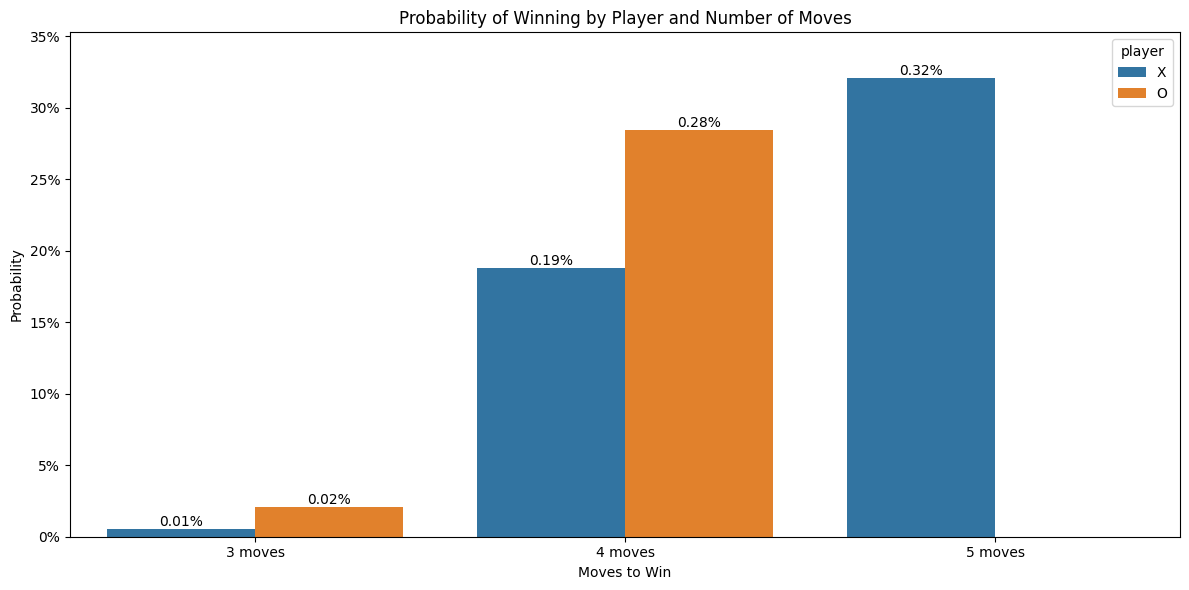


Based on this chart, it is highly unlikely to win in 3 moves for either player. 
Player 1 (X) can win in up to 3 opportunities to win (5 moves overall), while Player 2 (O) has 2 opportunities (4 moves overall).
Therefore, Player 1 (x) will always be more likely to win.


In [ ]:
# 1. Bar Chart: Probability of Winning by Player and Number of Moves per player
# Combine the data and set the correct order
combined_data = pd.concat([x_wins.assign(player='X'), o_wins.assign(player='O')])
move_order = ['3 moves', '4 moves', '5 moves']

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='moves_to_win', y='probability', hue='player',
                 data=combined_data, order=move_order)

# Modify y-axis to show percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.ylim(0, combined_data['probability'].max() * 1.1)  # Set y-axis limit with some headroom

plt.title('Probability of Winning by Player and Number of Moves')
plt.xlabel('Moves to Win')
plt.ylabel('Probability')

# Add percentage labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='edge')

plt.tight_layout()
plt.show()

print("\nBased on this chart, it is highly unlikely to win in 3 moves for either player. "
"\nPlayer 1 (X) can win in up to 3 opportunities to win (5 moves overall), while Player 2 (O) has 2 opportunities (4 moves overall)."
"\nTherefore, Player 1 (x) will always be more likely to win.")

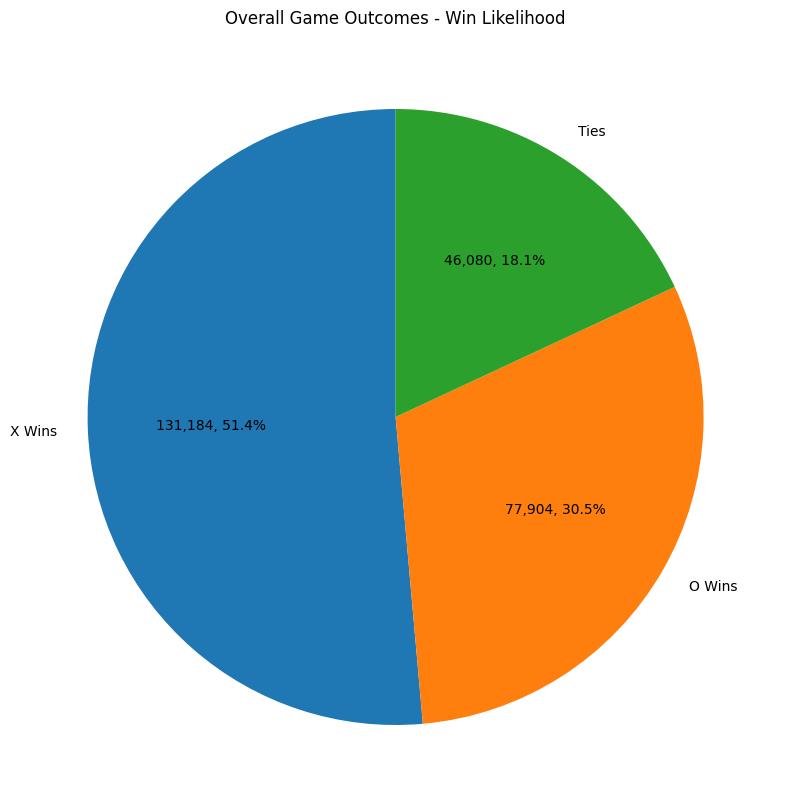

In [ ]:
# 2. Pie Chart: Overall Game Outcomes - Win Likelihood
# Calculate the total number of games for each outcome
x_total = x_wins['games_count'].sum()
o_total = o_wins['games_count'].sum()
tie_total = ties

# Create a function to format the labels
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val:,}, {pct:.1f}%'  # Using ',' format specifier for thousands separator
    return my_autopct

# Create the pie chart
plt.figure(figsize=(10, 10))
plt.pie([x_total, o_total, tie_total],
        labels=['X Wins', 'O Wins', 'Ties'],
        autopct=make_autopct([x_total, o_total, tie_total]),
        startangle=90)
plt.title('Overall Game Outcomes - Win Likelihood')
plt.show()

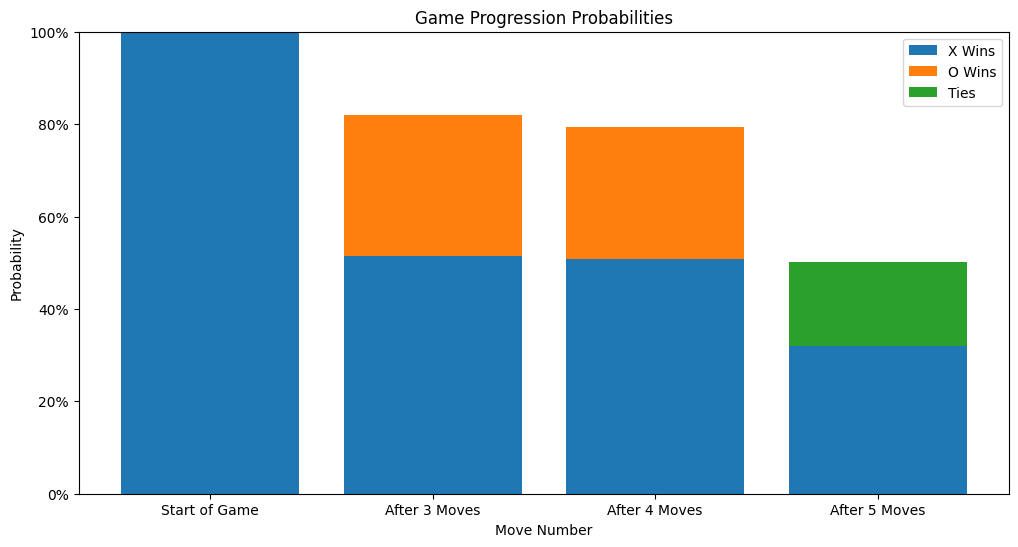


At the start of the game, X has all options so X is 100% likely to win 
After 3 moves overall, Player O has a chance up until 5 moves overall
After 5 moves overall, it is more likely Player X will win, but the only other option is a tie. Player 0 has no chance.


In [ ]:
# 3. Stacked Bar Chart: Game Progression Probabilities for X and O
x_probs = [1, x_wins['probability'].sum(), x_wins.loc[x_wins['moves_to_win'] != '3 moves', 'probability'].sum(),
           x_wins.loc[x_wins['moves_to_win'] == '5 moves', 'probability'].sum()]
o_probs = [0, o_wins['probability'].sum(), o_wins.loc[o_wins['moves_to_win'] == '4 moves', 'probability'].sum(), 0]
tie_probs = [0, 0, 0, tie_probability]

plt.figure(figsize=(12, 6))
plt.bar(range(4), x_probs, label='X Wins')
plt.bar(range(4), o_probs, bottom=x_probs, label='O Wins')
plt.bar(range(4), tie_probs, bottom=[sum(x) for x in zip(x_probs, o_probs)], label='Ties')

plt.xlabel('Move Number')
plt.ylabel('Probability')
plt.title('Game Progression Probabilities')
plt.legend()
plt.xticks(range(4), ['Start of Game', 'After 3 Moves', 'After 4 Moves', 'After 5 Moves'])

# Modify y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.ylim(0, 1)  # Set y-axis limits from 0 to 100%

plt.show()

print("\nAt the start of the game, X has all options so X is 100% likely to win "
"\nAfter 3 moves overall, Player O has a chance up until 5 moves overall"
"\nAfter 5 moves overall, it is more likely Player X will win, but the only other option is a tie. Player 0 has no chance.")